<a href="https://colab.research.google.com/github/lesther-santana/CISC_5450/blob/main/CISC5450_Math_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization

In [ ]:
!pip install sodapy

In [ ]:
import numpy as np
import scipy.stats as ss

In [ ]:
import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
client = Socrata("data.cityofnewyork.us", None)
vehicles = client.get("bm4k-52h4", query = """
                                  SELECT UNIQUE_ID, COLLISION_ID, DRIVER_SEX,CONTRIBUTING_FACTOR_1, CONTRIBUTING_FACTOR_2
                                  WHERE CRASH_DATE BETWEEN '2016-01-01' AND '2021-12-31'
                                  LIMIT 10000000""")
vehicles_df = pd.DataFrame.from_records(vehicles).astype({'UNIQUE_ID':'float', 'COLLISION_ID': 'float'})
del vehicles

person = client.get("f55k-p6yu", query = """
                                  SELECT unique_id, collision_id, ped_role, person_sex, person_age
                                  WHERE CRASH_DATE BETWEEN '2016-01-01' AND '2021-12-31'
                                  LIMIT 10000000""")
person_df = pd.DataFrame.from_records(person).astype({'collision_id': 'float', 'person_age': 'float'})
del person

crashes = client.get("h9gi-nx95", query="""
SELECT crash_date, crash_time, collision_id, number_of_persons_injured, number_of_persons_killed, number_of_pedestrians_injured, number_of_pedestrians_killed,
number_of_cyclist_injured, number_of_cyclist_killed, number_of_motorist_injured, number_of_motorist_killed, borough, contributing_factor_vehicle_1, contributing_factor_vehicle_2, 
zip_code
WHERE CRASH_DATE BETWEEN '2016-01-01' AND '2021-12-31'
LIMIT 10000000""")
crashes_df = pd.DataFrame.from_records(crashes).astype({'collision_id': 'float',
                                'number_of_persons_injured':'float', 'number_of_persons_killed': 'float',
                                'number_of_pedestrians_injured':'float', 'number_of_pedestrians_killed':'float',
                                'number_of_cyclist_injured':'float', 'number_of_cyclist_killed':'float',
                                'number_of_motorist_injured':'float', 'number_of_motorist_killed':'float'})
del crashes
crashes_df['crash_date'] = pd.to_datetime(crashes_df.crash_date + ' ' + crashes_df.crash_time)
#crashes_df = crashes_df[crashes_df.crash_date >= '2016-01-01'].drop('crash_time',axis=1)
crashes_df['Month'] = pd.DatetimeIndex(crashes_df['crash_date']).month
crashes_df['DayOfWeek'] = crashes_df['crash_date'].dt.day_name()
crashes_df['StartOfWeek'] = crashes_df.apply(lambda row: row['crash_date'] - dt.timedelta(days=row['crash_date'].weekday()), axis=1).dt.date
crashes_df['Year'] = crashes_df.crash_date.dt.year
crashes_df['Injured Persons'] = crashes_df.number_of_persons_injured.map(lambda x: 1 if x > 0 else 0)
crashes_df['Killed Persons'] = crashes_df.number_of_persons_killed.map(lambda x: 1 if x > 0 else 0)
crashes_df['Tragic Accident'] = crashes_df.apply(lambda x: 1 if x.number_of_persons_injured> 0 or x.number_of_persons_killed > 0 else 0, axis=1)

### Vehicle df copy with filtered Contributing Attributes

In [ ]:
exclude = ["Unspecified", "80","1"]
vehicular_factors = [
               "Accelerator Defective",
               "Brakes Defective",
               "Headlights Defective",
               "Other Lighting Defects",
               "Other Vehicular",
               "Oversized Vehicle",
               "Steering Failure",
               "Tire Failure/Inadequate",
               "Tow Hitch Defective",
               "Windshield Inadequate",
               "Driverless/Runaway Vehicle",
               "Vehicle Vandalism"
               ]

environment_factors = [
                       "Animals Action",
                       "Glare",
                       "Lane Marking Improper/Inadequate",
                       "Obstruction/Debris",
                       "Pavement Defective",
                       "Pavement Slippery",
                       "Shoulders Defective/Improper",
                       "Traffic Control Device Improper/Non-Working",
                       "View Obstructed/Limited"
                       ]

# Create a copy to use it on the 3 graphs
filtered_factors = vehicles_df[~vehicles_df.CONTRIBUTING_FACTOR_1.isin(exclude)]
filtered_factors.loc[filtered_factors["CONTRIBUTING_FACTOR_1"].isin(vehicular_factors), "CONTRIBUTING_FACTOR_1"] = 'Vehicular'
filtered_factors.loc[filtered_factors["CONTRIBUTING_FACTOR_1"].isin(environment_factors), "CONTRIBUTING_FACTOR_1"] = 'Environment'

filtered_factors.loc[filtered_factors["CONTRIBUTING_FACTOR_1"].isin(['Cell Phone (hand-Held)','Cell Phone (hand-held)','Cell Phone (hands-free)']), "CONTRIBUTING_FACTOR_1"] = 'Cell Phone'
filtered_factors.loc[filtered_factors["CONTRIBUTING_FACTOR_1"].isin(['Drugs (Illegal)', 'Drugs (illegal)']), "CONTRIBUTING_FACTOR_1"] = 'Drugs'
filtered_factors.loc[filtered_factors["CONTRIBUTING_FACTOR_1"].isin(['Illnes']), "CONTRIBUTING_FACTOR_1"] = 'Illness'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Helper function for correlation

Helper function for cramer's V. 

Source: [Categorical features correlation](https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792)

In [ ]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

## Time Series Plots of Y for X

In [ ]:
crashes_df.StartOfWeek.value_counts().describe()

count     314.000000
mean     3590.133758
std      1136.551232
min       826.000000
25%      2301.250000
50%      4065.000000
75%      4496.000000
max      5357.000000
Name: StartOfWeek, dtype: float64

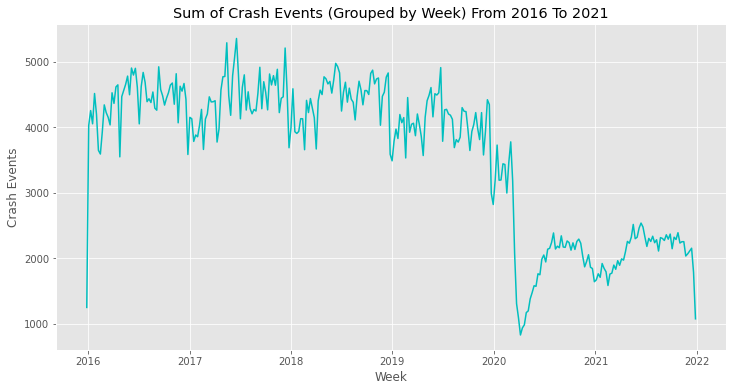

In [ ]:
plt.figure(figsize=(12,6))
crashes_df.StartOfWeek.value_counts().plot(c='c')
plt.title('Sum of Crash Events (Grouped by Week) From 2016 To 2021')
plt.ylabel('Crash Events')
plt.xlabel('Week');

In [ ]:
crashes_df.groupby('StartOfWeek')['number_of_persons_injured'].sum().describe()

count     314.000000
mean     1084.945860
std       218.988191
min       269.000000
25%       985.250000
50%      1129.500000
75%      1239.500000
max      1497.000000
Name: number_of_persons_injured, dtype: float64

In [ ]:
crashes_df.groupby('StartOfWeek')['number_of_persons_injured'].sum().sort_values(ascending=False)

StartOfWeek
2019-06-24    1497.0
2016-09-12    1423.0
2016-06-06    1411.0
2017-06-26    1409.0
2018-05-21    1399.0
               ...  
2020-04-20     345.0
2020-03-23     328.0
2020-04-06     312.0
2020-03-30     281.0
2020-04-13     269.0
Name: number_of_persons_injured, Length: 314, dtype: float64

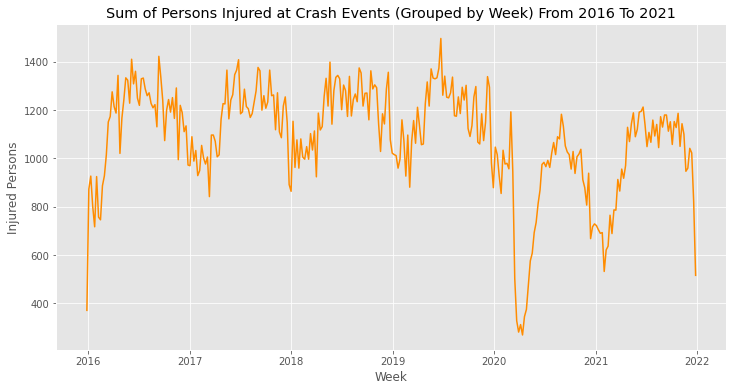

In [ ]:
plt.figure(figsize=(12,6))
crashes_df.groupby('StartOfWeek')['number_of_persons_injured'].sum().plot(c='darkorange')
plt.title('Sum of Persons Injured at Crash Events (Grouped by Week) From 2016 To 2021')
plt.ylabel('Injured Persons')
plt.xlabel('Week');

In [ ]:
crashes_df.groupby('StartOfWeek')['number_of_persons_killed'].sum().describe()

count    314.000000
mean       4.901274
std        2.503633
min        0.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       13.000000
Name: number_of_persons_killed, dtype: float64

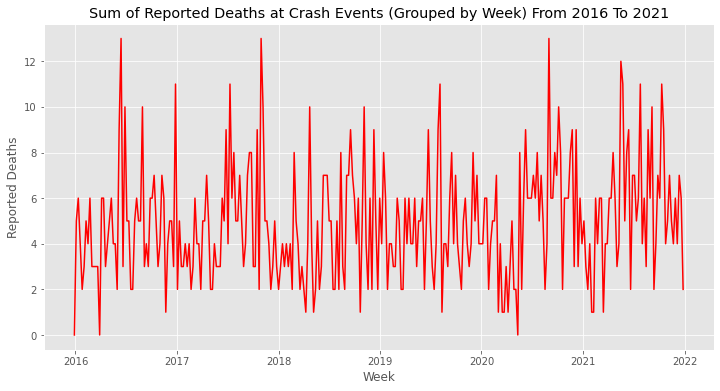

In [ ]:
plt.figure(figsize=(12,6))
crashes_df.groupby('StartOfWeek')['number_of_persons_killed'].sum().plot(c='r')
plt.title('Sum of Reported Deaths at Crash Events (Grouped by Week) From 2016 To 2021')
plt.ylabel('Reported Deaths')
plt.xlabel('Week');

In [ ]:
crashes_df.DayOfWeek.value_counts()

Friday       180300
Thursday     170200
Tuesday      166188
Wednesday    164982
Monday       160816
Saturday     151570
Sunday       133246
Name: DayOfWeek, dtype: int64

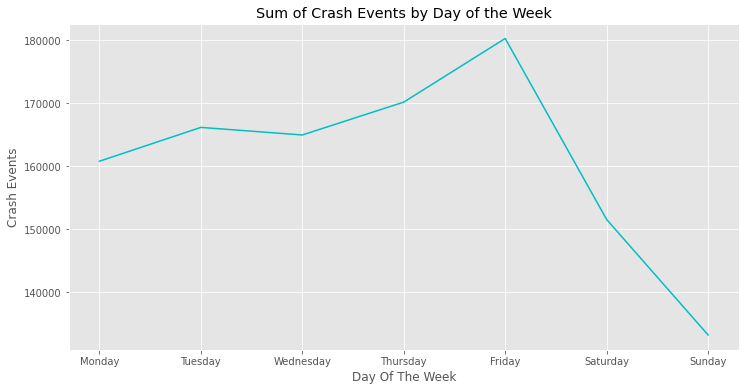

In [ ]:
# for histogram
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12,6))
crashes_df.DayOfWeek.value_counts().loc[dow_order].plot(c='c')
plt.title('Sum of Crash Events by Day of the Week')
plt.xlabel('Day Of The Week')
plt.ylabel('Crash Events');

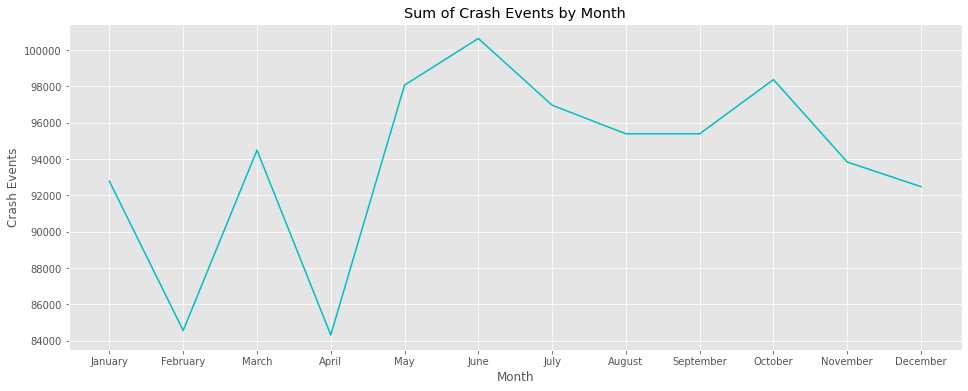

In [ ]:
# for histogram
plt.figure(figsize=(16,6))
crashes_df.Month.value_counts().loc[[x+1 for x in range(12)]].plot(kind='line',c='c')
plt.xticks([x+1 for x in range(12)], list(calendar.month_name)[1:])
plt.title('Sum of Crash Events by Month')
plt.xlabel('Month')
plt.ylabel('Crash Events');

In [ ]:
crashes_df.Month.value_counts().loc[[x+1 for x in range(12)]].sort_values()

4      84312
2      84557
12     92479
1      92780
11     93838
3      94489
8      95391
9      95395
7      96967
5      98074
10     98377
6     100643
Name: Month, dtype: int64

## Cummulative Plots

### Crash events

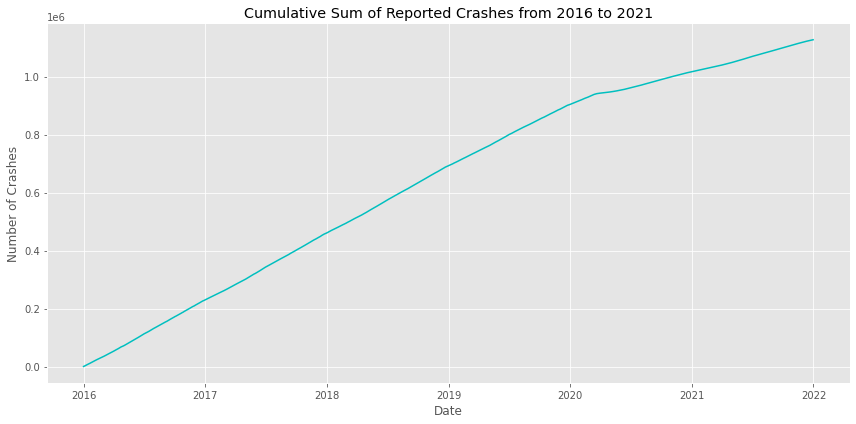

In [ ]:
crashes_df.loc[:,['crash_date']].crash_date.dt.date.value_counts(sort=False).to_frame().cumsum().plot(legend=None, figsize=(12,6),c='c')
plt.title('Cumulative Sum of Reported Crashes from 2016 to 2021')
plt.ylabel('Number of Crashes')
plt.xlabel('Date')
plt.tight_layout();

### Number of Persons Injured

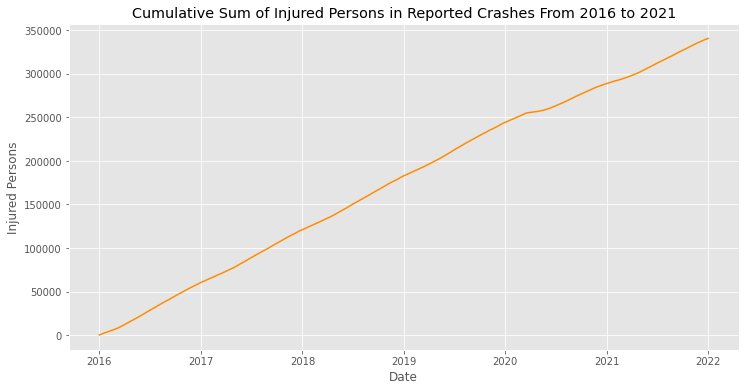

In [ ]:
a = crashes_df.loc[:,['crash_date','number_of_persons_injured']]
a['date'] = a['crash_date'].dt.date
a.groupby('date').sum().cumsum().plot(legend=None, c='darkorange', figsize=(12,6))
plt.title('Cumulative Sum of Injured Persons in Reported Crashes From 2016 to 2021')
plt.ylabel('Injured Persons')
plt.xlabel('Date');

### Number of Persons Killed by Year

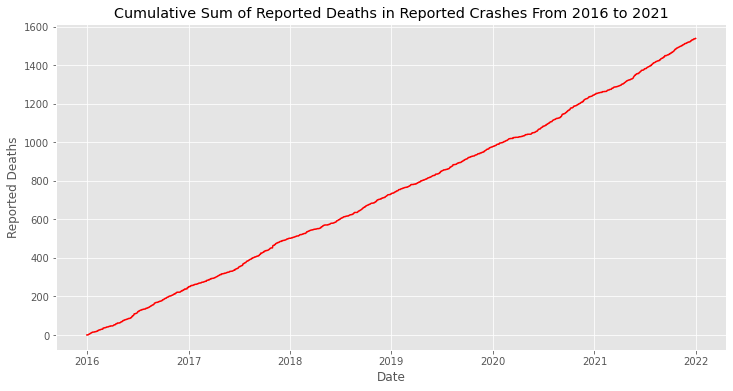

In [ ]:
a = crashes_df.loc[:,['crash_date','number_of_persons_killed']]
a['date'] = a['crash_date'].dt.date
a.groupby('date').sum().cumsum().plot(legend=None, c='r', figsize=(12,6))
plt.title('Cumulative Sum of Reported Deaths in Reported Crashes From 2016 to 2021')
plt.ylabel('Reported Deaths')
plt.xlabel('Date');

### placeholder

In [ ]:
count, bins = crashes_df.Year.astype({'Year':'str'}).value_counts().values, crashes_df.Year.astype({'Year':'str'}).value_counts().index
pdf = count/sum(count)
cum_sum = np.cumsum(pdf)

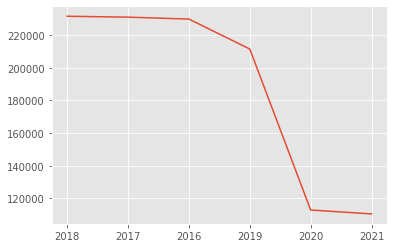

In [ ]:
plt.plot(crashes_df.Year.astype({'Year':'str'}).value_counts())

In [ ]:
crashes_df[crashes_df['Injured Persons']==1].Year.value_counts()

2018    45600
2019    45253
2017    44500
2016    44058
2021    38579
2020    33184
Name: Year, dtype: int64

In [ ]:
crashes_df.groupby('Year')['number_of_persons_killed'].sum()

Year
2016    246.0
2017    256.0
2018    231.0
2019    244.0
2020    269.0
2021    293.0
Name: number_of_persons_killed, dtype: float64

In [ ]:
import matplotlib

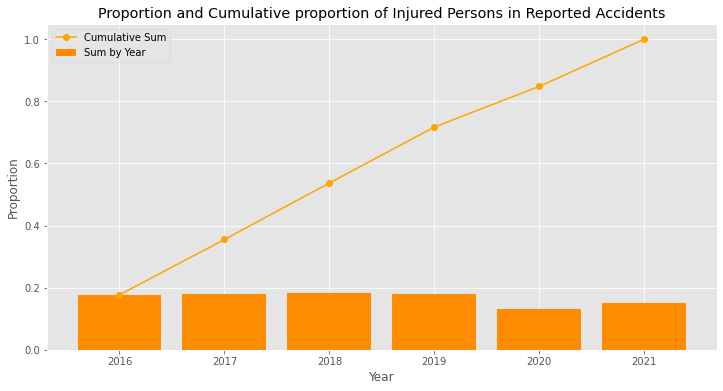

In [ ]:
count, bins = crashes_df.groupby('Year')['number_of_persons_injured'].sum().values, crashes_df.groupby('Year')['number_of_persons_injured'].sum().index
count = count/sum(count)
cum_sum = np.cumsum(count)

plt.figure(figsize=(12,6))
plt.ylabel("Proportion")
plt.xlabel('Year')
plt.bar(bins, count, color="darkorange", label="Sum by Year")
plt.plot(bins, cum_sum, color='orange',label="Cumulative Sum",marker='o')
plt.legend()
plt.title('Proportion and Cumulative proportion of Injured Persons in Reported Accidents');

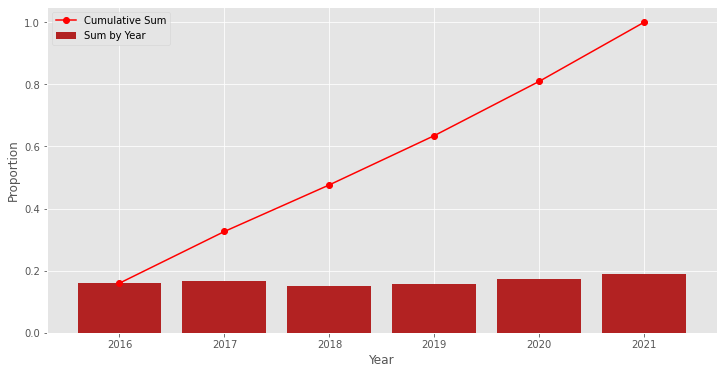

In [ ]:
count, bins = crashes_df.groupby('Year')['number_of_persons_killed'].sum().values, crashes_df.groupby('Year')['number_of_persons_killed'].sum().index
count = count/sum(count)
cum_sum = np.cumsum(count)

plt.figure(figsize=(12,6))
plt.ylabel("Proportion")
plt.xlabel('Year')
plt.bar(bins, count, color="firebrick", label="Sum by Year")

plt.plot(bins, cum_sum, color='red',label="Cumulative Sum",marker='o')
plt.legend();

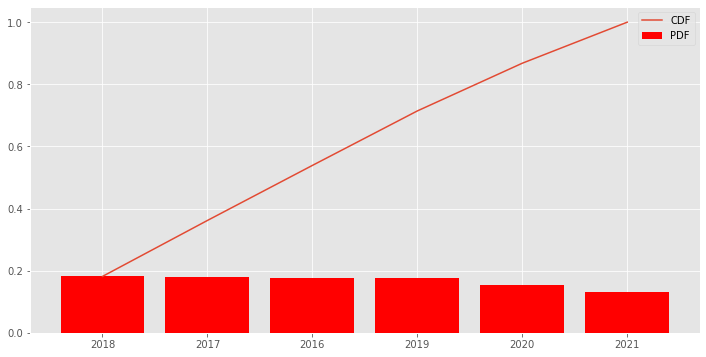

In [ ]:
# to check
count, bins = crashes_df[crashes_df['Injured Persons']==1].Year.astype({'Year':'str'}).value_counts().values, crashes_df.Year.astype({'Year':'str'}).value_counts().index
pdf = count/sum(count)
cum_sum = np.cumsum(pdf)

plt.figure(figsize=(12,6))
plt.bar(bins, pdf, color="red", label="PDF")
plt.plot(bins, cum_sum, label="CDF")
plt.legend()

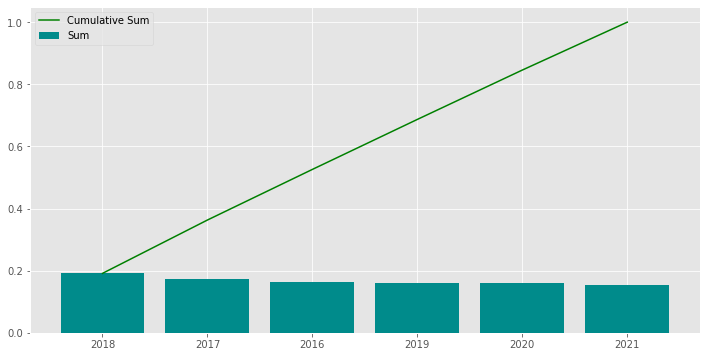

In [ ]:
# to check
count, bins = crashes_df[crashes_df['Killed Persons']==1].Year.astype({'Year':'str'}).value_counts().values, crashes_df.Year.astype({'Year':'str'}).value_counts().index
count = count/sum(count)
cum_sum = np.cumsum(count)

plt.figure(figsize=(12,6))
plt.bar(bins, count, color="darkcyan", label="Sum")
plt.plot(bins, cum_sum, color='green',label="Cumulative Sum")
plt.legend();

## Percentage Change

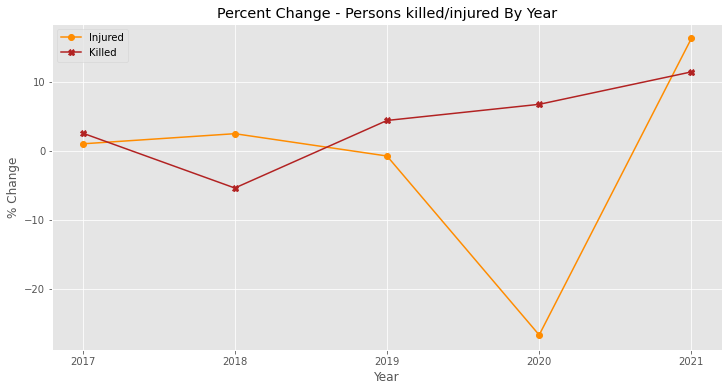

In [ ]:
plt.figure(figsize=(12,6))
(crashes_df.groupby('Year')['Injured Persons'].sum().pct_change() * 100).plot(kind='line', color='darkorange', marker='o')
(crashes_df.groupby('Year')['Killed Persons'].sum().pct_change() * 100).plot(kind='line', color='firebrick', marker='X')
plt.ylabel('% Change')
plt.title('Percent Change - Persons killed/injured By Year')
plt.xlabel('Year')
plt.xticks([2017, 2018, 2019, 2020, 2021])
plt.legend(['Injured', 'Killed']);

In [ ]:
(crashes_df.groupby('Year')['Injured Persons'].sum().pct_change() * 100)

Year
2016          NaN
2017     1.003223
2018     2.471910
2019    -0.760965
2020   -26.670055
2021    16.257835
Name: Injured Persons, dtype: float64

In [ ]:
df_group = pd.DataFrame([crashes_df.groupby('Year')['Injured Persons'].sum(),(crashes_df.groupby('Year')['Injured Persons'].sum().pct_change() * 100),
                         crashes_df.groupby('Year')['Killed Persons'].sum(), (crashes_df.groupby('Year')['Killed Persons'].sum().pct_change() * 100)]).transpose()
df_group.columns = ['Injured Persons', 'Injured Persons Pct. Change', 'Killed Persons', 'Killed Persons Pct. Change']
df_group

,Injured Persons,Injured Persons Pct. Change,Killed Persons,Killed Persons Pct. Change
Year,,,,
2016,44058.0,NaN,235.0,NaN
2017,44500.0,1.003223,241.0,2.553191
2018,45600.0,2.471910,228.0,-5.394191
2019,45253.0,-0.760965,238.0,4.385965
2020,33184.0,-26.670055,254.0,6.722689
2021,38579.0,16.257835,283.0,11.417323


## Scatter Plot of Y for X

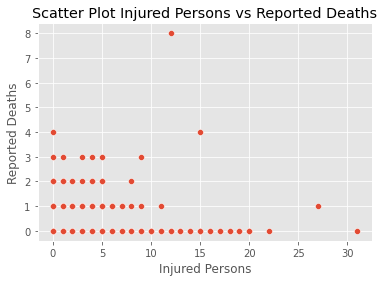

In [ ]:
sns.scatterplot(data=crashes_df, x='number_of_persons_injured', y='number_of_persons_killed')
plt.title('Scatter Plot Injured Persons vs Reported Deaths')
plt.ylabel('Reported Deaths')
plt.xlabel('Injured Persons');

## Barchart for Diff Xs and Properties Y

### Amount of crash events by zip code

Top zip codes by crash events amount (zip_code == NA excluded)

In [ ]:
top_zip = crashes_df.zip_code.value_counts().to_frame()
top_zip["pct"] = (top_zip["zip_code"] / top_zip.zip_code.sum())* 100
top_zip["cum_sum"] = top_zip.pct.cumsum()
top_zip[:10]

,zip_code,pct,cum_sum
11207,14309,1.965042,1.965042
11236,10701,1.469558,3.434600
11234,9999,1.373153,4.807753
11385,9758,1.340057,6.147810
11212,9651,1.325363,7.473173
11203,9610,1.319732,8.792905
11101,9314,1.279083,10.071988
11208,9291,1.275924,11.347912
11226,9233,1.267959,12.615871
11434,9151,1.256698,13.872570


### Amount of crash events by Borough

In [ ]:
crashes_df.borough.value_counts(dropna=False)

NaN              398922
BROOKLYN         234796
QUEENS           201387
MANHATTAN        148129
BRONX            116244
STATEN ISLAND     27824
Name: borough, dtype: int64

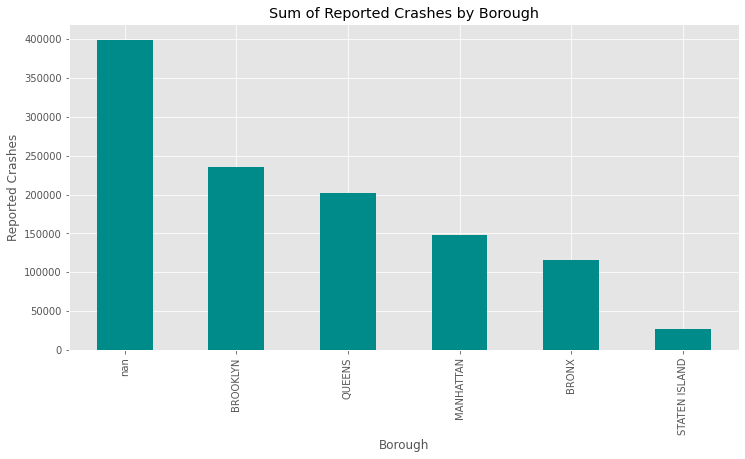

In [ ]:
crashes_df.borough.value_counts(dropna=False).plot(kind='bar', color='darkcyan', figsize=(12,6))
plt.title('Sum of Reported Crashes by Borough')
plt.xlabel('Borough')
plt.ylabel('Reported Crashes');

### Distribution of reported injuries and deaths by type

Reported injuries amount by type


In [ ]:
crashes_df.groupby('Year').sum(numeric_only=True)[["number_of_pedestrians_injured","number_of_cyclist_injured","number_of_motorist_injured"]].describe()

,number_of_pedestrians_injured,number_of_cyclist_injured,number_of_motorist_injured
count,6.000000,6.000000,6.000000
mean,9687.333333,5018.500000,41673.500000
std,2035.083356,289.858414,5623.670536
min,6689.000000,4725.000000,32340.000000
25%,8269.250000,4906.750000,38881.500000
50%,10829.000000,4967.500000,44312.500000
75%,11114.750000,4983.250000,45529.250000
max,11151.000000,5576.000000,46070.000000


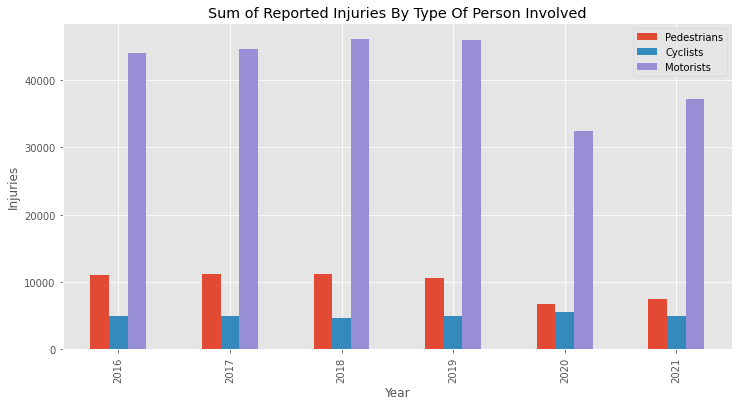

In [ ]:
crashes_df.groupby('Year').sum(numeric_only=True)[["number_of_pedestrians_injured","number_of_cyclist_injured","number_of_motorist_injured"]].plot(kind="bar", figsize=(12,6))
plt.title('Sum of Reported Injuries By Type Of Person Involved')
plt.ylabel('Injuries')
plt.legend(['Pedestrians', 'Cyclists', 'Motorists']);

Reported deaths amount by type

In [ ]:
crashes_df.groupby('Year').sum(numeric_only=True)[["number_of_pedestrians_killed","number_of_cyclist_killed","number_of_motorist_killed"]].describe()

,number_of_pedestrians_killed,number_of_cyclist_killed,number_of_motorist_killed
count,6.000000,6.000000,6.000000
mean,126.833333,22.333333,105.000000
std,15.131645,8.041559,26.623298
min,102.000000,10.000000,72.000000
25%,124.000000,18.250000,86.000000
50%,128.000000,23.000000,102.500000
75%,130.500000,28.500000,126.500000
max,149.000000,31.000000,138.000000


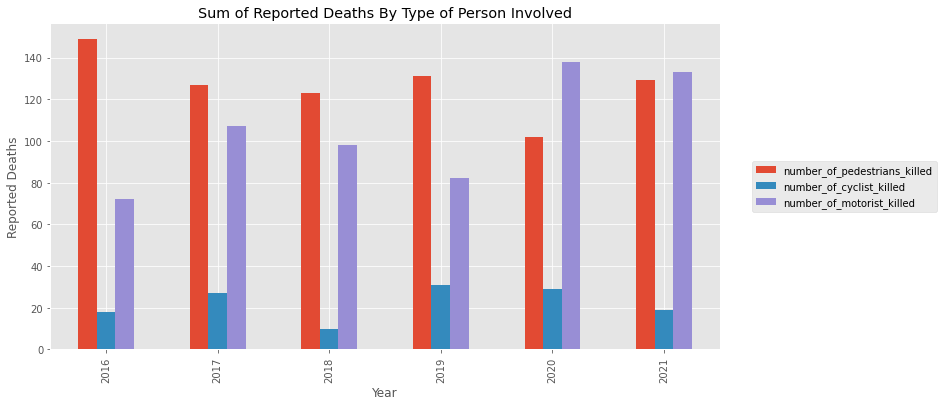

In [ ]:
crashes_df.groupby('Year').sum(numeric_only=True)[["number_of_pedestrians_killed","number_of_cyclist_killed","number_of_motorist_killed"]].plot(kind="bar", figsize=(12,6))
plt.title('Sum of Reported Deaths By Type of Person Involved')
plt.ylabel('Reported Deaths')
plt.legend(['Pedestrians', 'Cyclists', 'Motorists'])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left");

### Motor vehicle involved in a crash by Driver's sex.

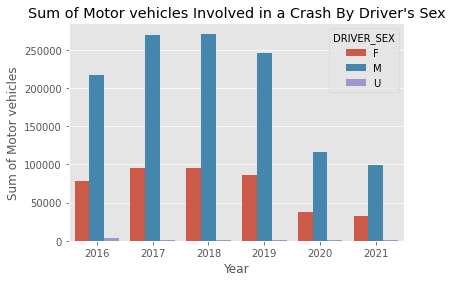

In [ ]:
sex_year = pd.merge(vehicles_df, crashes_df[["collision_id", "Year"]], how="left", left_on="COLLISION_ID", right_on="collision_id").groupby(['Year','DRIVER_SEX'])['UNIQUE_ID'].count().to_frame().reset_index()
sns.barplot(data=sex_year, x="Year", y="UNIQUE_ID", hue="DRIVER_SEX")
plt.title("Sum of Motor vehicles Involved in a Crash By Driver's Sex")
plt.ylabel('Sum of Motor vehicles')
del sex_year

## Boxplots of Xs for their Properties Y

Vehicles involved in collision boxplot by borough

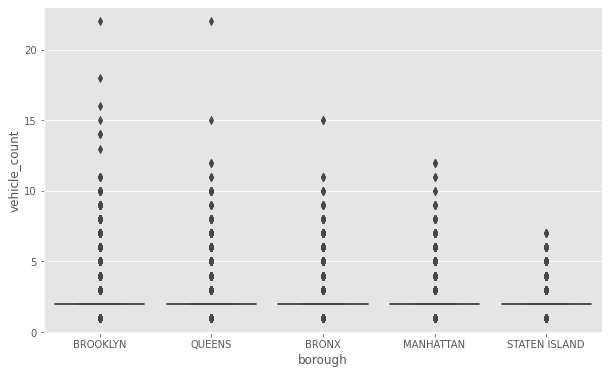

In [ ]:
box = vehicles_df.COLLISION_ID.value_counts().to_frame().reset_index().rename(columns={"COLLISION_ID": "vehicle_count"}).merge(crashes_df[["collision_id", "borough"]], left_on="index", right_on="collision_id")
plt.figure(figsize=(10,6))
sns.boxplot(x="borough", y="vehicle_count", data=box)
del box

Persons involved in collision boxplot by borough

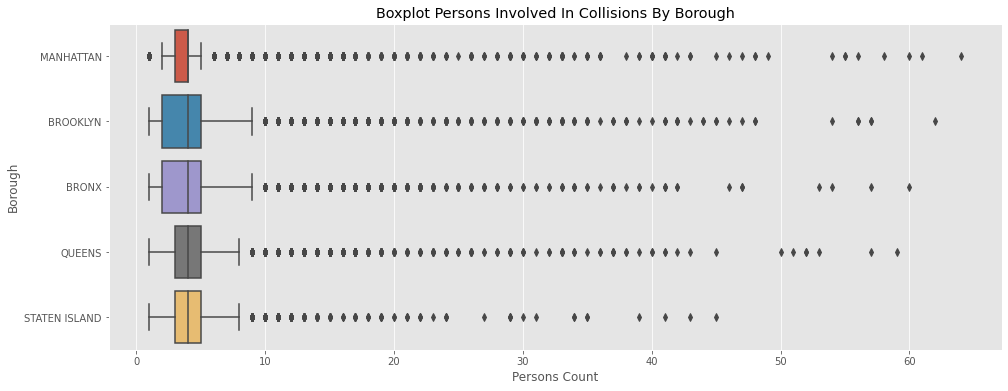

In [ ]:
box = person_df.collision_id.value_counts().to_frame().reset_index().rename(columns={"collision_id": "person_count"}).merge(crashes_df[["collision_id", "borough"]], left_on="index", right_on="collision_id")
plt.figure(figsize=(16,6))
sns.boxplot(y="borough", x="person_count", data=box, orient='h')
plt.xlabel('Persons Count')
plt.ylabel('Borough')
plt.title('Boxplot Persons Involved In Collisions By Borough');
#del box

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


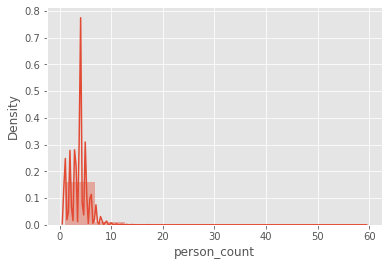

In [ ]:
sns.distplot(box[box.borough == 'QUEENS'].person_count, bins=10)

## Draw the Histogram of all Y for all X

Text(0.5, 1.0, "Histograms People's Ages involved at accidents")

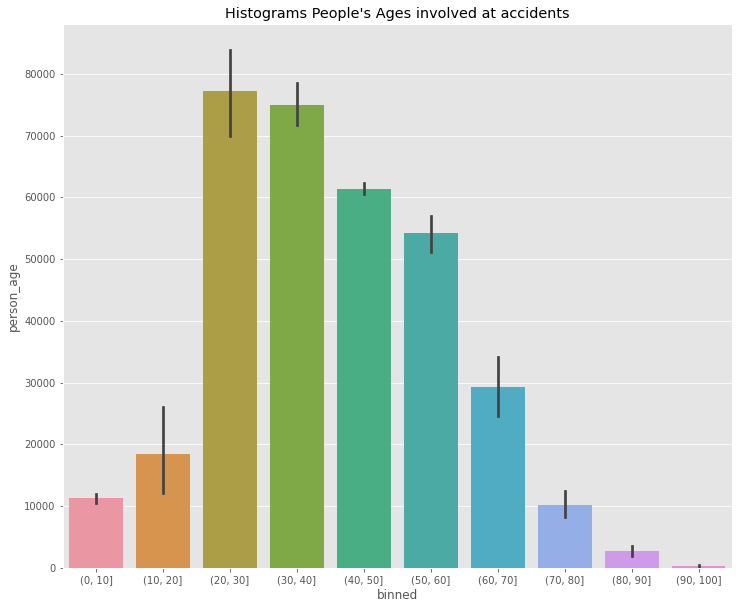

In [ ]:
histo = person_df[(person_df.person_age >0) & (person_df.person_age <=100)].person_age.value_counts().to_frame().reset_index().rename(columns={"index": "age"})
histo.age = histo.age.astype('int')
histo["binned"] = pd.cut(histo.age, np.arange(0,101,10))
plt.figure(figsize=(12,10))
sns.barplot(data=histo, x="binned", y="person_age")
plt.title("Histograms People's Ages involved at accidents")

In [ ]:
person_df[person_df.person_age > 90]

,unique_id,collision_id,ped_role,person_sex,person_age
913,10252464,4229741.0,Passenger,M,91.0
2881,10251916,4230071.0,Passenger,F,1027.0
3077,10256011,4231939.0,Driver,F,94.0
3294,10251917,4230071.0,Passenger,F,1061.0
3623,10251914,4230071.0,Registrant,M,1056.0
...,...,...,...,...,...
4349568,12070309,4488877.0,Registrant,M,95.0
4355410,12075427,4490268.0,Registrant,F,96.0
4355790,12078618,4491291.0,Registrant,M,92.0
4357613,12078611,4491291.0,Driver,M,92.0


### Crash events by hour

In [ ]:
crashes_df.crash_date.dt.hour.value_counts()

16    80967
17    79477
14    75788
15    71817
18    69246
13    64956
12    61946
8     61324
9     58581
11    58311
19    56324
10    55029
20    46452
0     41253
21    40002
22    36793
7     36009
23    30831
6     25765
1     19075
5     15974
2     14433
4     14270
3     12679
Name: crash_date, dtype: int64

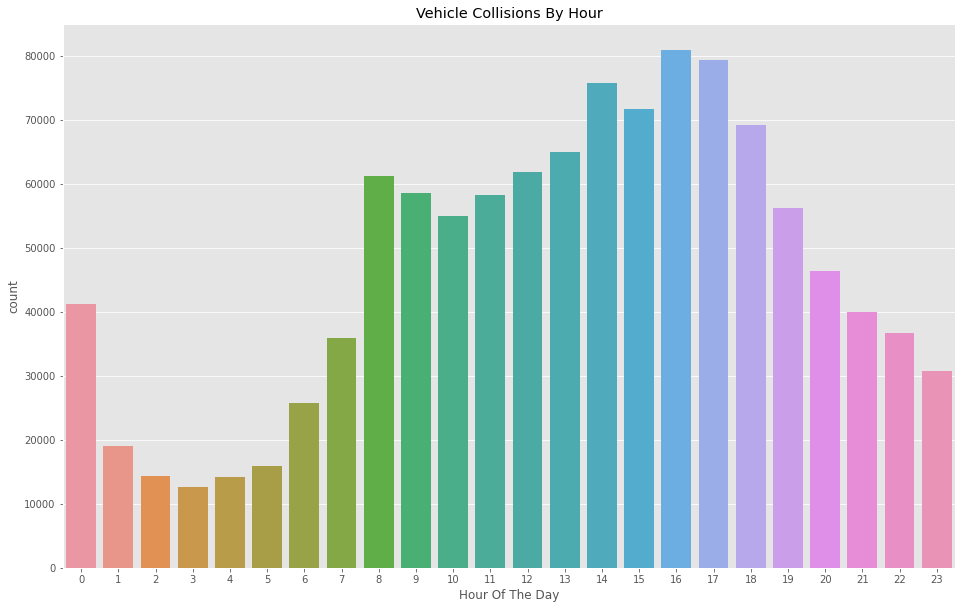

In [ ]:
plt.figure(figsize=(16,10))
sns.countplot(x=crashes_df.crash_date.dt.hour)
plt.title('Vehicle Collisions By Hour')
plt.xlabel('Hour Of The Day');

### Injuries by hour

In [ ]:
crashes_df.groupby(crashes_df.crash_date.dt.hour)['number_of_persons_injured'].sum().sort_values()

crash_date
3      4840.0
2      5446.0
4      5465.0
5      5495.0
1      6917.0
6      7907.0
7     10554.0
23    12603.0
10    12667.0
9     13788.0
0     14135.0
11    14240.0
22    14486.0
21    15699.0
8     15703.0
12    15841.0
20    17198.0
13    17299.0
19    19250.0
14    20742.0
15    21805.0
18    22217.0
16    22559.0
17    23817.0
Name: number_of_persons_injured, dtype: float64

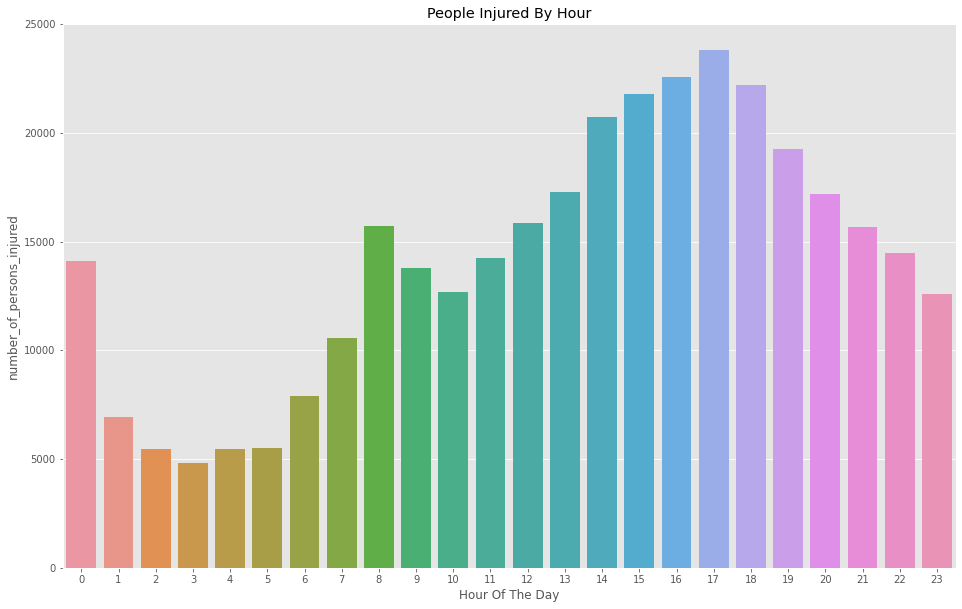

In [ ]:
b = crashes_df.groupby(crashes_df.crash_date.dt.hour)['number_of_persons_injured'].sum().to_frame().reset_index()
b
plt.figure(figsize=(16,10))
sns.barplot(x=b.crash_date, y=b.number_of_persons_injured)
plt.title('People Injured By Hour')
plt.xlabel('Hour Of The Day');

### Deaths by hour

In [ ]:
crashes_df.groupby(crashes_df.crash_date.dt.hour)['number_of_persons_killed'].sum().sort_values()

crash_date
7     41.0
11    46.0
8     47.0
9     47.0
14    49.0
12    49.0
2     51.0
1     58.0
15    58.0
5     60.0
10    61.0
13    62.0
16    63.0
6     67.0
3     68.0
19    69.0
22    71.0
17    77.0
18    77.0
20    78.0
21    81.0
0     86.0
4     86.0
23    87.0
Name: number_of_persons_killed, dtype: float64

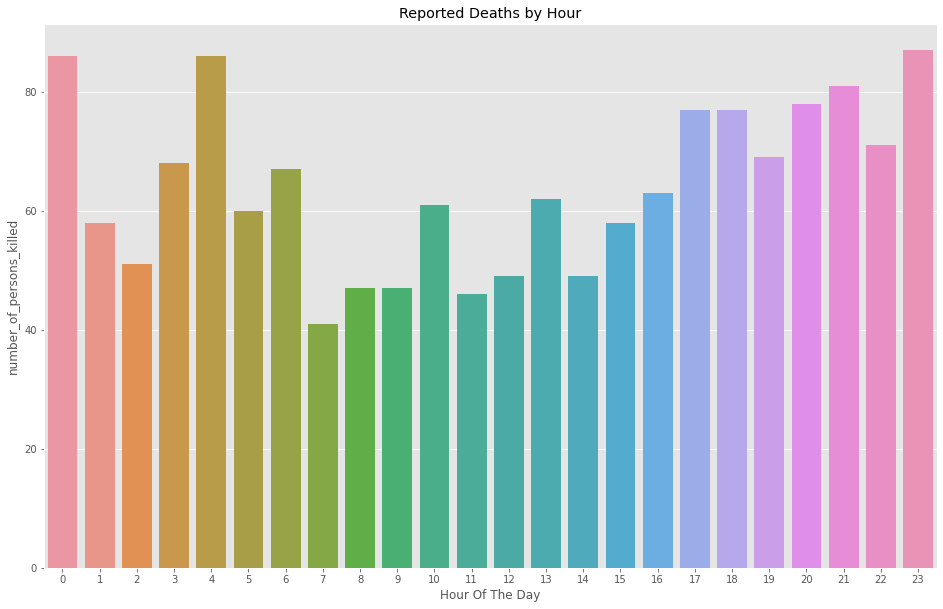

In [ ]:
b = crashes_df.groupby(crashes_df.crash_date.dt.hour)['number_of_persons_killed'].sum().to_frame().reset_index()
b
plt.figure(figsize=(16,10))
sns.barplot(x=b.crash_date, y=b.number_of_persons_killed)
plt.title('Reported Deaths by Hour')
plt.xlabel('Hour Of The Day');

## Heatmap of Correlations for Y with other Attributes

### Df transformations

In [ ]:
# Driver Sex and contributing factors
sex_factors = filtered_factors.loc[:, ["DRIVER_SEX","CONTRIBUTING_FACTOR_1"]].dropna()

# For Contributing factors and Hour
data_time = filtered_factors.merge(crashes_df[["collision_id","crash_date"]], left_on="COLLISION_ID", right_on="collision_id")
data_time["hour"] = data_time.crash_date.dt.hour
data_time = data_time.loc[:,["CONTRIBUTING_FACTOR_1","hour"]].dropna()

ik_cor = filtered_factors.merge(crashes_df[["collision_id",'number_of_persons_injured','number_of_persons_killed']], left_on="COLLISION_ID", right_on="collision_id")
# Injured and contributing factors
#injured = filtered_factors.merge(ik_cor[["collision_id","Injured Persons"]], left_on="COLLISION_ID", right_on="collision_id")

# Death and contributing factors
#killed = filtered_factors.merge(ik_cor[["collision_id","Killed Persons"]], left_on="COLLISION_ID", right_on="collision_id")

### "Hour", "Driver_Sex","Contributing_Factor", "Injured_People", "Killed_People"

In [ ]:
labels = ["Hour", "Driver_Sex","Contributing_Factor", 'number_of_persons_injured', 'number_of_persons_killed']
labels.sort()
corr_mat = pd.DataFrame(np.eye(len(labels)),columns=labels, index=labels)

corr_mat.loc["Driver_Sex","Contributing_Factor"] = cramers_v(pd.crosstab(sex_factors["DRIVER_SEX"], sex_factors["CONTRIBUTING_FACTOR_1"])[:-1].values)
corr_mat.loc["Contributing_Factor","Driver_Sex"] = corr_mat.loc["Driver_Sex","Contributing_Factor"]
corr_mat.loc["Hour","Contributing_Factor"] = cramers_v(pd.crosstab(data_time["hour"], data_time["CONTRIBUTING_FACTOR_1"]).values)
corr_mat.loc["Contributing_Factor","Hour"]= corr_mat.loc["Hour","Contributing_Factor"]
corr_mat.loc["Hour",'number_of_persons_killed'] = cramers_v(pd.crosstab(crashes_df["crash_date"].dt.hour, crashes_df['number_of_persons_killed']).values)
corr_mat.loc['number_of_persons_killed',"Hour"] = corr_mat.loc["Hour",'number_of_persons_killed']
corr_mat.loc["Hour",'number_of_persons_injured'] = cramers_v(pd.crosstab(crashes_df["crash_date"].dt.hour, crashes_df['number_of_persons_injured']).values)
corr_mat.loc['number_of_persons_injured', "Hour"]= corr_mat.loc["Hour",'number_of_persons_injured']
corr_mat.loc["Contributing_Factor",'number_of_persons_injured'] = cramers_v(pd.crosstab(ik_cor["CONTRIBUTING_FACTOR_1"], ik_cor['number_of_persons_injured']).values)
corr_mat.loc['number_of_persons_injured', "Contributing_Factor"] = corr_mat.loc["Contributing_Factor",'number_of_persons_injured']
corr_mat.loc["Contributing_Factor",'number_of_persons_killed'] = cramers_v(pd.crosstab(ik_cor["CONTRIBUTING_FACTOR_1"], ik_cor['number_of_persons_killed']).values)
corr_mat.loc['number_of_persons_killed',"Contributing_Factor"] = corr_mat.loc["Contributing_Factor",'number_of_persons_killed']

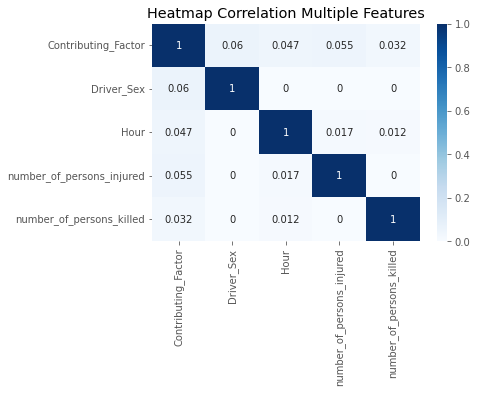

In [ ]:
sns.heatmap(corr_mat, annot=True, annot_kws={"size": 10}, cmap="Blues")
plt.title('Heatmap Correlation Multiple Features');

### Contributing Factors Correlations

In [ ]:
table = pd.pivot_table(filtered_factors.loc[:,["COLLISION_ID","CONTRIBUTING_FACTOR_1"]], index='COLLISION_ID', columns='CONTRIBUTING_FACTOR_1', aggfunc=len, fill_value=0)
table_corr = table.corr()

Text(0.5, 1.0, 'Heatmap Correlation Between Reported Vehicle Collisions Contributing Factors')

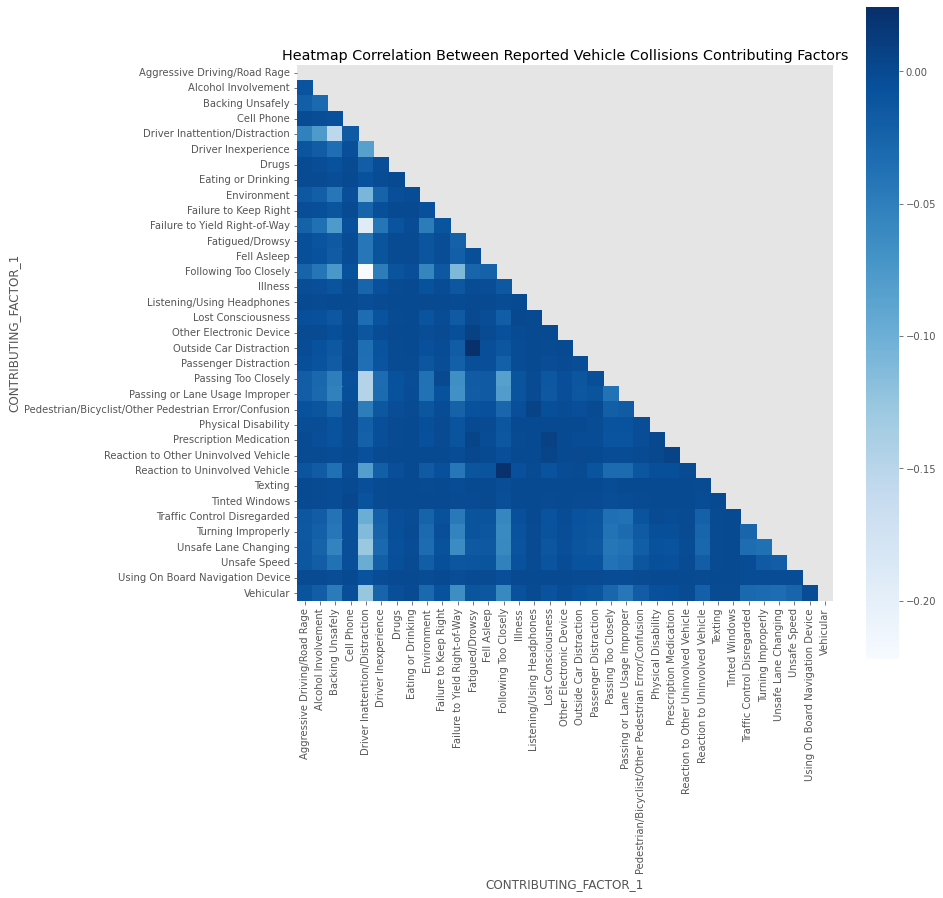

In [ ]:
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(table_corr)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask
plt.figure(figsize=(12,12))
sns.heatmap(table_corr, mask=mask, square=True, cmap="Blues")
plt.title('Heatmap Correlation Between Reported Vehicle Collisions Contributing Factors')

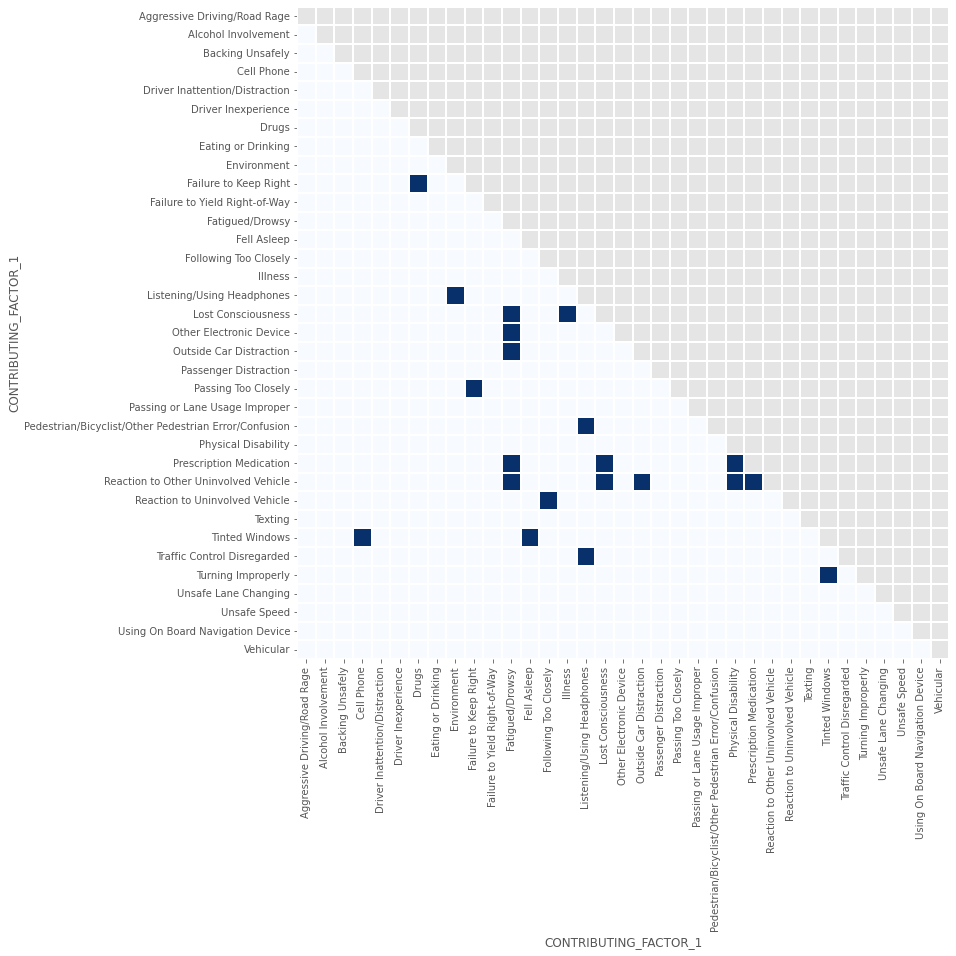

In [ ]:
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(table_corr)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask
plt.figure(figsize=(12,12))
t = table_corr
t[t>0] = 100
sns.heatmap(t, mask=mask, square=True, cmap="Blues",linewidths=1, cbar=False)

## Model

In [ ]:
! pip install category_encoders

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score

X = crashes_df[~crashes_df['contributing_factor_vehicle_1'].isna()]['contributing_factor_vehicle_1']
#y = crashes_df[~crashes_df['contributing_factor_vehicle_1'].isna()]['number_of_persons_injured'].fillna(0)
y = crashes_df[~crashes_df['contributing_factor_vehicle_1'].isna()]['Injured Persons'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20,)

In [ ]:
import category_encoders as ce 
catboostE = ce.CatBoostEncoder(cols=['contributing_factor_vehicle_1'])
X_train = catboostE.fit_transform(X_train, y_train).fillna(0)#.apply(lambda x: np.float32(x.contributing_factor_vehicle_1), axis=1)
#X_train = ohe.fit_transform(X_train.values.reshape(1,-1))
X_test = catboostE.transform(X_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#lr = LinearRegression()
lr = LogisticRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
#mean_absolute_error(y_test, preds)
accuracy_score(y_test, preds)

0.7809278809350021

## Hypothesis Testing

In [ ]:
import statsmodels.api as sm

In [ ]:
stat_data = pd.pivot_table(filtered_factors.loc[:,["COLLISION_ID","CONTRIBUTING_FACTOR_1"]], index='COLLISION_ID', columns='CONTRIBUTING_FACTOR_1', aggfunc=lambda x: 1, fill_value=0).reset_index()
stat_data.columns.name = None
stat_data = stat_data.merge(crashes_df[["collision_id","number_of_persons_injured"]], left_on="COLLISION_ID", right_on="collision_id")
stat_data = stat_data[stat_data["number_of_persons_injured"] > 0]

In [ ]:
X_train = stat_data.loc[:,~stat_data.columns.isin(['COLLISION_ID', 'collision_id', 'number_of_persons_injured'])]
y_train = stat_data.loc[:,'number_of_persons_injured']

In [ ]:
import statsmodels.api as sm
X_train_lm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                                OLS Regression Results                               
Dep. Variable:     number_of_persons_injured   R-squared:                       0.023
Model:                                   OLS   Adj. R-squared:                  0.022
Method:                        Least Squares   F-statistic:                     129.3
Date:                       Tue, 03 May 2022   Prob (F-statistic):               0.00
Time:                               16:22:34   Log-Likelihood:            -2.4594e+05
No. Observations:                     195860   AIC:                         4.920e+05
Df Residuals:                         195824   BIC:                         4.923e+05
Df Model:                                 35                                         
Covariance Type:                   nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------